# ESM3 Analysis Calculation and Plotting Functions
For the ESM3Analysis notepads a variety of functions are used for calculations and plotting. This notepad quickly imports the ESM3 data and stores the various methods for calculation and plotting.

#### Dask import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34386")
client

Client Scheduler: tcp://127.0.0.1:34386 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 38.65 GB


#### Imports

In [2]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


#### Data loading

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq('thetao') & df.experiment_id.eq('historical') & df.source_id.eq('E3SM-1-0')]
dfArea = df[df.variable_id.eq('areacello') & df.source_id.eq('CESM2')]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[1]), consolidated=True)
dataAreaRaw = dsArea.areacello

for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='SetId') #Combining data sets

latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
dataFiltLatLev = fileSet.thetao.sel(lat=latSel, lev=5.0) #Selection of latitude and depth
dataFiltFull = dataFiltLatLev.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dataFiltFull["time"][0].values
globalDateInc = dataFiltFull["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dataFiltFull["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data loaded")

Data loaded


#### Calculations

In [4]:
@delayed
def meanTemp(dataSet):
    '''Calculates and returns Mean Ocean temperature for a given data set.
    Requires global dataAreaSH, totalArea'''
    return (dataSet*dataAreaSH).sum(dim=['lon', 'lat']) / totalArea 

dataAreaSH = dataAreaRaw.sel(lat=latSel) #Selecting data for relevant latittude
totalArea = dataAreaSH.sum(dim=['lon', 'lat']) #Summing selected area

def dateCheck1(Date):
    '''Takes date input, check to ensure that date is valid for the data set, modifying it if not.
    Requires global globalStartDate, globalEndDate, globalStartDateStr, globalEndDateStr'''
    if np.datetime64(Date ,'M') < globalStartDate:
        Date = globalStartDateStr
    elif np.datetime64(Date ,'M') > globalEndDateOut:
        Date = globalEndDateInStr
    return Date

def dateCheck2(startDate, endDate):
    '''Takes start and end date input, check to ensure that both dates are valid for the data set, modifying them if not.
    Requires global globalStartDate, globalEndDate, globalStartDateStr, globalEndDateStr'''
    if np.datetime64(startDate ,'M') > np.datetime64(endDate ,'M'):
        startDate, endDate = endDate, startDate
    if np.datetime64(startDate ,'M') < globalStartDate:
        startDate = globalStartDateStr
        if np.datetime64(endDate ,'M') < globalStartDate:
            endDate = globalStartDateStr
    if np.datetime64(endDate ,'M') > globalEndDateOut:
        endDate = globalEndDateOutStr
        if np.datetime64(startDate ,'M') > globalEndDateOut:
            startDate = globalEndDateInStr
    return startDate, endDate

def singleSoloDateCalc(date,setId,plotNo):
    '''Calculates and displays Ocean temperature for a selected date, prints mean ocean temperature, uses only 1 data set.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    singleData = dataFiltFull.sel(SetId=setId, time=date)
    singleTemp = meanTemp(singleData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(singleData,date, valuesSingleTemp.values[0], setId, plotNo)
    
def singleAllDateCalc(date, stdBool, plotNo):
    '''Calculates and displays Ocean temperature for a selected date, prints mean ocean temperature, averages all data sets.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    multiData = dataFiltFull.sel(time=date)
    meanData = multiData.mean("SetId", keep_attrs =True)
    meanData.compute()
    multiTemps = meanTemp(multiData)
    valuesMultiTemps = multiTemps.compute()
    valuesMeanTemp = valuesMultiTemps.mean("SetId")
    valuesMeanTemp.compute()
    singleTimePlot(meanData, date, valuesMeanTemp.values[0], "All", plotNo)
    if stdBool:
        stdData = multiData.std("SetId", keep_attrs =True)
        stdData.compute()
        valuesStdTemp = stdData.mean(["lon", "lat"])
        valuesStdTemp.compute()
        singleTimePlotStd(stdData, date, valuesStdTemp.values[0], plotNo+1)

def rangeSoloCompareCalc(startDate, endDate, setId, plotNo):
    '''Calculates and displays change in Ocean temperature for two dates for a given data set, prints mean ocean temperature at both time dates and the difference.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    startData = dataFiltFull.sel(SetId=setId, time=startDate)
    endData = dataFiltFull.sel(SetId=setId, time=endDate)
    diffData = startData.copy()
    diffData.values = (endData.values - startData.values)
    singleTemp = meanTemp(diffData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(diffData,endDate+" vs "+startDate, valuesSingleTemp.values[0], setId, plotNo)
    
def rangeAllCompareCalc(startDate, endDate, stdBool, plotNo):
    '''Calculates and displays change in Ocean temperature for two dates for a given data set, prints mean ocean temperature at both time dates and the difference.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    startData = dataFiltFull.sel(time=startDate)
    endData = dataFiltFull.sel(time=endDate)
    diffData = startData.copy()
    diffData.values = (endData.values - startData.values)
    meanDiffData = diffData.mean("SetId", keep_attrs =True)
    meanDiffData.compute()
    singleTemp = meanTemp(meanDiffData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(meanDiffData,endDate+" vs "+startDate, valuesSingleTemp.values[0], "All", plotNo)
    if stdBool:
        stdData = diffData.std("SetId", keep_attrs =True)
        stdData.compute()
        valuesStdTemp = stdData.mean(["lon", "lat"])
        valuesStdTemp.compute()
        singleTimePlotStd(stdData, endDate+" vs "+startDate, valuesStdTemp.values[0], plotNo+1)
    
def rangeSoloDateCalc(startDate, endDate, setId, plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses only 1 data set.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    startDate, endDate = dateCheck2(startDate, endDate)
    multiData = dataFiltFull.sel(SetId=setId, time=slice(startDate, endDate))
    multiTemp = meanTemp(multiData)
    valuesMultiTemp = multiTemp.compute()
    multiTimePlot(valuesMultiTemp, startDate, endDate, setId, plotNo)

def rangeAllDateCalc(startDate, endDate, stdBool , plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses all data sets.
    Requires global dataFiltFull, dataAreaSH, totalArea. Use for small time ranges (1 month - 12 months)'''
    startDate, endDate = dateCheck2(startDate, endDate)
    multiDatas = dataFiltFull.sel(time=slice(startDate, endDate))
    multiTemps = meanTemp(multiDatas)
    valuesMultiTemps = multiTemps.compute()
    meanMultiTemp = valuesMultiTemps.mean("SetId", keep_attrs =True)
    meanMultiTemp.compute()
    multiTimePlot(meanMultiTemp, startDate, endDate, 'All', plotNo)
    if stdBool:
        stdMultiTemp = valuesMultiTemps.std("SetId", keep_attrs =True)
        stdMultiTemp.compute()
        multiTimePlotStd(stdMultiTemp, startDate, endDate, plotNo + 1)
    
def rangeAllDateCalc2(startDate, endDate, stdBool, plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses all data sets.
    Requires global dataFiltFull, dataAreaSH, totalArea. Use for large time ranges (6 months +)'''
    startDate, endDate = dateCheck2(startDate, endDate)
    dateArrayPart = np.arange(np.datetime64(startDate ,'M'), np.datetime64(endDate ,'M'), np.timedelta64(12, 'M')) #Splits dates into 12 month segments
    dateArrayFull = np.append(dateArrayPart, np.datetime64(endDate, 'M')) #Appends end date
    if (dateArrayFull[-2]+np.timedelta64(5,'M')) > dateArrayFull[-1]:
        dateArrayFull[-2] = dateArrayFull[-1] - np.timedelta64(6,'M')
    fullTempsList = []
    for i in range(len(dateArrayFull)-2):
        partData = dataFiltFull.sel(time = slice(dateArrayFull[i], dateArrayFull[i+1] - np.timedelta64(1, 'M') ))
        partTemps = meanTemp(partData)
        valuesMultiTemps = partTemps.compute()
        fullTempsList.append(valuesMultiTemps)
    partData = dataFiltFull.sel(time = slice(dateArrayFull[-2], dateArrayFull[-1]))
    partTemps = meanTemp(partData)
    valuesMultiTemps = partTemps.compute()
    fullTempsList.append(valuesMultiTemps)
    fullTemps = xr.combine_nested(fullTempsList, concat_dim="time")   
    meanFullTemp = fullTemps.mean("SetId", keep_attrs =True)
    meanFullTemp.compute()
    multiTimePlot(meanFullTemp, startDate, endDate, 'All', plotNo)
    if stdBool:
        stdFullTemp = fullTemps.std("SetId", keep_attrs =True)
        stdFullTemp.compute()
        multiTimePlotStd(stdFullTemp, startDate, endDate, plotNo + 1)
        
def rangeSoloCompareCal(startDate1, startDate2, months, setId, plotNo):
    startDate1 = np.datetime64(startDate1, 'M')
    startDate2 = np.datetime64(startDate2, 'M')
    endDate1 = startDate1 + np.timedelta64(months-1, 'M')
    endDate2 = startDate2 + np.timedelta64(months-1, 'M')
    subData1 = dataFiltFull.sel(time=slice(startDate1, endDate1),SetId=setId)
    subData2 = dataFiltFull.sel(time=slice(startDate2, endDate2),SetId=setId)
    subData2copy = subData2.copy()
    timeDiff = startDate2 - startDate1
    
    for i in range(months):
        subData2copy['time'].values[i] = np.datetime64(subData2['time'].values[i], 'M') - timeDiff

    multiSub1 = meanTemp(subData1)
    valuesSub1Temps = multiSub1.compute()
    multiSub2 = meanTemp(subData2copy)
    valuesSub2Temps = multiSub2.compute()
    multiTimePlotCompare(valuesSub1Temps, valuesSub2Temps, str(startDate1), str(startDate2), months,str(setId),plotNo)   
        
print("Calculation functions defined")

Calculation functions defined


#### Plotting Functions

In [5]:
def singleTimePlot(dataSet, date, meanValue, setStr, plotNo):
    '''Displays Ocean temperature for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo)
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp - " + str(date) + " ("+str(setStr)+")")
    print("Average Ocean temperature for plot "+str(plotNo)+" ("+date+")(Set "+str(setStr)+"): "+str(round(meanValue.values[0],3))+" Celsius")
    
def singleTimePlotStd(dataSet, date, stdValue, plotNo):
    '''Displays Ocean temperature standard deviation for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo)
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp Std - " + str(date))
    print("Average Ocean temperature standard deviation for plot "+str(plotNo)+" ("+date+"): "+str(round(stdValue,3))+" Celsius")
    
def multiTimePlot(dataSet, startDate, endDate, setStr, plotNo):
    '''Displays Ocean temperature for given data set as line graph'''
    plt.figure(plotNo)
    dataSet.plot(label='Monthly Mean')
    if (np.datetime64(startDate,'M') + np.timedelta64(12,'M')) < np.datetime64(endDate,'M'): #Check to ensure there is sufficent range in the data set for rolling average
        dataSetRollingMean = dataSet.rolling(time=12).mean()
        dataSetRollingMean.plot(label='12 month rolling mean')
        print("Mean Annual rolling Temp on "+str(np.datetime64(startDate,'M')+np.timedelta64(11, 'M'))+" (set "+str(setStr)+"): "+str(round(dataSetRollingMean.values[11], 3))+" Celcius")
        print("Mean Annual rolling Temp on "+str(endDate)+" (set "+str(setStr)+"): "+str(round(dataSetRollingMean.values[-1],3))+" Celcius")
        print("Mean Rolling Temp increase across time (set "+str(setStr)+"): "+str(round(dataSetRollingMean.values[-1] - dataSetRollingMean.values[11],4))+" Celcius")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Mean Southern Ocean Temp - " + str(startDate)+" to "+str(endDate))
    
def multiTimePlotCompare(dataSet1, dataSet2, startDate1, startDate2, months, setStr, plotNo):
    '''Displays Ocean temperature for two given data sets as a line graph'''
    plt.figure(plotNo)
    dataSet1.plot(label='Monthly Mean for '+startDate1+" series")
    dataSet2.plot(label='Monthly Mean for '+startDate2+" series")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Mean Southern Ocean Temp - " + str(startDate1)+" and "+str(startDate2)+" for "+str(months)+" months (Set "+setStr+")")
    
def multiTimePlotStd(dataSet, startDate, endDate, plotNo):
    '''Displays Ocean temperature standard devation for given data set as line graph'''
    plt.figure(plotNo)
    dataSet.plot(label='Monthly Std')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Mean Southern Ocean Temp Deviation - " + str(startDate)+" to "+str(endDate)+" ("+str(fileCount)+" datasets)")
    
print("Plotting functions defined")

Plotting functions defined


#### Testing

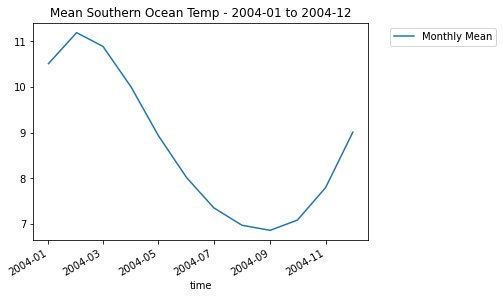

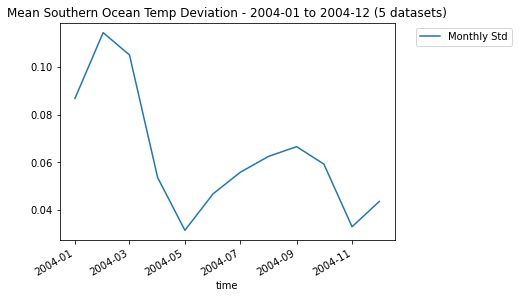

In [6]:
rangeAllDateCalc('2004-01','2004-12', True, 1)

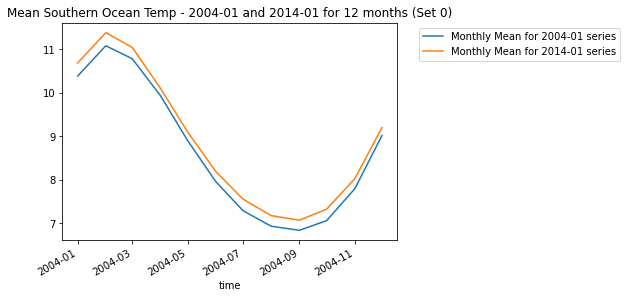

In [7]:
rangeSoloCompareCal('2004-01','2014-01',12,0,1)